In [1]:
# Standard imports
import pandas as pd
import sys 
import os
import seaborn as sns
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=0.8, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

%config InlineBackend.figure_format='svg'

# Define study
STUDY_NAME = "opt_flathv_75_1500_withBB_chroma15_eol_evolution_chroma_2228"
PARQUET_PATH = f"../../scans/{STUDY_NAME}/da.parquet"
CONF_MAD_PATH = f"../../scans/{STUDY_NAME}/base_collider/config.yaml"
CONF_COLLIDER_PATH = f"../../scans/{STUDY_NAME}/base_collider/xtrack_0004/config.yaml"

SAVE_STUDY_EOS = False

In [2]:
######
# ! Warning: this class is probably not up to date

#### Imports
import os
import numpy as np
import yaml
import json
import sys
import importlib
import pickle
import xtrack as xt
import xmask as xm
import xmask.lhc as xlhc


#### Build collider class
class BuildCollider:
    def __init__(self, path_configuration, save_collider_before_bb=True):
        """Initialize the BuildCollider class."""

        # Configuration path
        self.path_configuration = path_configuration

        # Load configuration
        self.configuration = self.load_configuration()

        # Correct path in configuration
        self.correct_configuration()

        # Load and tune collider
        self.collider, self.collider_before_bb = self.load_and_tune_collider(
            save_collider_before_bb
        )
        
        # Build trackers for collider_before_bb
        if self.collider_before_bb is not None:
            self.collider_before_bb.build_trackers()

    def load_configuration(self):
        """Loads the configuration from a yaml file."""
        with open(self.path_configuration, "r") as fid:
            configuration = yaml.safe_load(fid)
        return configuration

    def correct_configuration(self):
        """Corrects the paths in the configuration file (from relative to absolute)."""
        self.configuration["config_simulation"]["collider_file"] = (
            self.path_configuration.split("config.yaml")[0]
            + self.configuration["config_simulation"]["collider_file"]
        )

        # ? Correction of the configuration files is not required anymore as they're produced locally
        # for lhcb in ["lhcb1", "lhcb2"]:
        #     self.configuration["config_collider"]["config_knobs_and_tuning"][
        #         "closed_orbit_correction"
        #     ][lhcb] = (
        #         self.path_configuration.split("config.yaml")[0]
        #         + self.configuration["config_collider"]["config_knobs_and_tuning"][
        #             "closed_orbit_correction"
        #         ][lhcb]
        #     )

    def load_and_tune_collider(self, save_collider_before_bb):
        """Build the collider using the same script as in the initial configuration file."""

        # Path of the 2_configure_and_track file
        path_configure_and_track = self.path_configuration.split("config.yaml")[0]
        name_module = "2_configure_and_track.py"
        # Check that the twiss and track file exists
        if not os.path.exists(path_configure_and_track + name_module):
            raise ValueError(
                "The 2_configure_and_track file does not exist in the same directory as the config"
                " file. No collider can be built ensuring reproducibility."
            )
        else:
            # Add to sys
            sys.path.insert(1, path_configure_and_track)

            # Import the module
            configure_and_track = importlib.import_module("2_configure_and_track")

        # Build collider
        if save_collider_before_bb:
            collider, _, collider_before_bb = configure_and_track.configure_collider(
                self.configuration["config_simulation"],
                self.configuration["config_collider"],
                save_collider=False,
                return_collider_before_bb=save_collider_before_bb,
            )
        else:
            collider, _ = configure_and_track.configure_collider(
                self.configuration["config_simulation"],
                self.configuration["config_collider"],
                save_collider=False,
                return_collider_before_bb=save_collider_before_bb,
            )
            collider_before_bb = None

        # Remove the folder "correction" which was created during the process
        os.system("rm -rf correction")
        # Remove other temporary files
        os.system("rm -rf .__*")

        return collider, collider_before_bb

    def dump_collider(self, prefix=None, suffix="collider.json", dump_before_bb=False):
        """Dumps the collider to a json file."""
        path_collider = (
            self.path_configuration.split("/scans/")[1]
            .split("config.yaml")[0]
            .replace("/", "_")[:-5]
        )
        if prefix is not None:
            path_collider = prefix + path_collider + suffix
        self.collider.to_json(path_collider)

        if self.collider_before_bb is not None and dump_before_bb:
            path_collider_before_bb = path_collider.replace(".json", "_before_bb.json")
            self.collider_before_bb.to_json(path_collider_before_bb)
            return path_collider, path_collider_before_bb
        elif self.collider_before_bb is None and dump_before_bb:
            raise ValueError("No collider before beam-beam has been provided.")
        else:
            return path_collider

In [3]:
# Load dataframe
df = pd.read_parquet(PARQUET_PATH)

# Round all numbers to 3 decimals
df = df.round(3)
df

normalized amplitude in xy-plane      qx     qy   dqx  \
beam  i_bunch_b1 dqx                                                           
lhcb1 58         5.0                              6.438  62.313  60.32   5.0   
                 6.0                              6.625  62.313  60.32   6.0   
                 7.0                              6.656  62.313  60.32   7.0   
                 8.0                              6.219  62.313  60.32   8.0   
                 9.0                              6.938  62.313  60.32   9.0   
                 10.0                             6.594  62.313  60.32  10.0   
                 11.0                             6.688  62.313  60.32  11.0   
                 12.0                             6.656  62.313  60.32  12.0   
                 13.0                             7.031  62.313  60.32  13.0   
                 14.0                             6.906  62.313  60.32  14.0   
                 15.0                             6.875  62.313  60.32  15.0   
      952        5.0                              6.469  62.313  60.32   5.0   
                 6.0                              6.406  62.313  60.32   6.0   
                 7.0                              6.219  62.313  60.32   7.0   
                 8.0                              6.438  62.313  60.32   8.0   
                 9.0                              6.125  62.313  60.32   9.0   
                 10.0                             6.500  62.313  60.32  10.0   
                 11.0                             6.531  62.313  60.32  11.0   
                 12.0                             6.500  62.313  60.32  12.0   
                 13.0                             6.688  62.313  60.32  13.0   
                 14.0                             6.625  62.313  60.32  14.0   
                 15.0                             6.281  62.313  60.32  15.0   

                        dqy  i_bunch_b1  i_bunch_b2  num_particles_per_bunch  
beam  i_bunch_b1 dqx                                                          
lhcb1 58         5.0   15.0        58.0      1144.0             1.316653e+11  
                 6.0   15.0        58.0      1144.0             1.316653e+11  
                 7.0   15.0        58.0      1144.0             1.316653e+11  
                 8.0   15.0        58.0      1144.0             1.316653e+11  
                 9.0   15.0        58.0      1144.0             1.316653e+11  
                 10.0  15.0        58.0      1144.0             1.316653e+11  
                 11.0  15.0        58.0      1144.0             1.316653e+11  
                 12.0  15.0        58.0      1144.0             1.316653e+11  
                 13.0  15.0        58.0      1144.0             1.316653e+11  
                 14.0  15.0        58.0      1144.0             1.316653e+11  
                 15.0  15.0        58.0      1144.0             1.316653e+11  
      952        5.0   15.0       952.0      1144.0             1.316653e+11  
                 6.0   15.0       952.0      1144.0             1.316653e+11  
                 7.0   15.0       952.0      1144.0             1.316653e+11  
                 8.0   15.0       952.0      1144.0             1.316653e+11  
                 9.0   15.0       952.0      1144.0             1.316653e+11  
                 10.0  15.0       952.0      1144.0             1.316653e+11  
                 11.0  15.0       952.0      1144.0             1.316653e+11  
                 12.0  15.0       952.0      1144.0             1.316653e+11  
                 13.0  15.0       952.0      1144.0             1.316653e+11  
                 14.0  15.0       952.0      1144.0             1.316653e+11  
                 15.0  15.0       952.0      1144.0             1.316653e+11

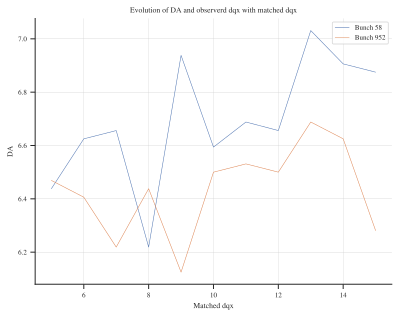

In [4]:
df_b58 = df[df["i_bunch_b1"] == 58]
df_b952 = df[df["i_bunch_b1"] == 952]

# Plot evolution of chroma for both bunches
plt.plot(df_b58["dqx"], df_b58["normalized amplitude in xy-plane"], label="Bunch 58")
plt.plot(df_b952["dqx"], df_b952["normalized amplitude in xy-plane"], label="Bunch 952")
plt.xlabel("Matched dqx")
plt.ylabel("DA")
plt.title("Evolution of DA and observerd dqx with matched dqx")
plt.legend()
plt.grid()
plt.show()

In [5]:
# Get effective chroma after bb
path_config_58 = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/opt_flathv_75_1500_withBB_chroma15_eol_evolution_chroma_2228/base_collider/xtrack_0000/config.yaml"
collider_58_before_bb = BuildCollider(path_config_58, save_collider_before_bb=True).collider_before_bb

path_config_952 = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/opt_flathv_75_1500_withBB_chroma15_eol_evolution_chroma_2228/base_collider/xtrack_0148/config.yaml"
collider_952_before_bb = BuildCollider(path_config_952, save_collider_before_bb=True).collider_before_bb

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Correcting closed orbit
Correcting IR1 left
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Found suitable prebuilt kernel `default_only_xtrack`.
Matching: model call n. 7       

Correcting IR1 right
Found suitable prebuilt kernel `default_only_xtrack`.
Matching: model call n. 7       

Correcting IR5 left
Found suitable prebuilt kernel `default_only_xtrack`.
Matching: model call n. 7       

Correcting IR5 right
Found suitable prebuilt kernel `default_only_xtrack`.
Matching: model call n. 7       

Correcting IP1
Found suitable prebuilt kernel `default_only_xtrack`.
Matching: model call n. 11       

Correcting IP2
F

b47fc2d191f4486fac93ab8f9ca536fe.c:4396: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from b47fc2d191f4486fac93ab8f9ca536fe.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


5827c809a5f440058cd7e8072c4a1dd7.c:4396: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 5827c809a5f440058cd7e8072c4a1dd7.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 


Done compiling ContextCpu kernels.
bb_lr.l1b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_22 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_23 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_24 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 The beams are longitudinally shifted
bb_lr.l2b1_16 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_20 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_22 Reference systems are not paral

221502a5dd3d40c597f9b8596f27fc3e.c:3698: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 221502a5dd3d40c597f9b8596f27fc3e.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


b14be2f7faf54f209de5c1ec73e35059.c:5694: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from b14be2f7faf54f209de5c1ec73e35059.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


rm: cannot remove '.__afs0C09': Device or resource busy
rm: cannot remove '.__afs1C1F': Device or resource busy
rm: cannot remove '.__afs355C': Device or resource busy
rm: cannot remove '.__afs7D11': Device or resource busy
rm: cannot remove '.__afs8914': Device or resource busy
rm: cannot remove '.__afsADFA': Device or resource busy
rm: cannot remove '.__afsB12B': Device or resource busy
rm: cannot remove '.__afsCCC4': Device or resource busy
rm: cannot remove '.__afsDD7C': Device or resource busy
rm: cannot remove '.__afsEE4E': Device or resource busy


Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Correcting closed orbit
Correcting IR1 left
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Found suitable prebuilt kernel `default_only_xtrack`.
Matching: model call n. 7       

Correcting IR1 right
Found suitable prebuilt kernel `default_only_xtrack`.
Matching: model call n. 7       

Correcting IR5 left
Found suitable prebuilt kernel `default_only_xtrack`.
Matching: model call n. 7       

Correcting IR5 right
Found 

72d5a13dfc634678b79dabc6f6ebb397.c:4396: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 72d5a13dfc634678b79dabc6f6ebb397.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


d181451a226c4d58a4a4414c0e40439e.c:4396: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from d181451a226c4d58a4a4414c0e40439e.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 


Done compiling ContextCpu kernels.
bb_lr.l1b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_22 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_23 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_24 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 The beams are longitudinally shifted
bb_lr.l2b1_16 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_20 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_22 Reference systems are not paral

rm: cannot remove '.__afs0C09': Device or resource busy
rm: cannot remove '.__afs1C1F': Device or resource busy
rm: cannot remove '.__afs355C': Device or resource busy
rm: cannot remove '.__afs6816': Device or resource busy
rm: cannot remove '.__afs7D11': Device or resource busy
rm: cannot remove '.__afs8914': Device or resource busy
rm: cannot remove '.__afs9B71': Device or resource busy
rm: cannot remove '.__afsADFA': Device or resource busy
rm: cannot remove '.__afsB12B': Device or resource busy
rm: cannot remove '.__afsCCC4': Device or resource busy
rm: cannot remove '.__afsDD7C': Device or resource busy
rm: cannot remove '.__afsEE4E': Device or resource busy


Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [ ]:
fname = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/master_jobs/filling_scheme/25ns_2228b_2216_1686_2112_hybrid_8b4e_2x56b_25ns_3x48b_12inj_with_identical_bunches.json"
with open(fname, "r") as fid:
    filling = json.load(fid)
filling_pattern_cw = filling["beam1"]
filling_pattern_acw = filling["beam2"]


In [ ]:
l_b = []
l_dqx58 = []
l_dqx952 = []
b2 = np.nonzero(filling_pattern_acw)[0][0]
for dqx in np.linspace(5,15,11, endpoint=True): 
    
    collider_58 = xt.Multiline.from_dict(collider_58_before_bb.to_dict())
    collider_952 = xt.Multiline.from_dict(collider_952_before_bb.to_dict())
    
    collider_58.build_trackers()
    collider_952.build_trackers()
    
    # Match chroma to dqx
    for line_name in ["lhcb1", "lhcb2"]:
        knob_names = conf_knobs_and_tuning["knob_names"][line_name]

        targets = {
            "dqx": dqx,
            "dqy": dqx,
        }

        xm.machine_tuning(
            line=collider_58[line_name],
            enable_closed_orbit_correction=True,
            enable_linear_coupling_correction=False,
            enable_tune_correction=True,
            enable_chromaticity_correction=True,
            knob_names=knob_names,
            targets=targets,
            line_co_ref=collider_58[line_name + "_co_ref"],
            co_corr_config=conf_knobs_and_tuning["closed_orbit_correction"][line_name],
        )
    
    # Loop over bunches and get the chromaticity everytime
    collider_58.apply_filling_pattern(
        filling_pattern_cw=filling_pattern_cw,
        filling_pattern_acw=filling_pattern_acw,
        i_bunch_cw=58,
        i_bunch_acw=b2,
    )
    collider_952.apply_filling_pattern(
        filling_pattern_cw=filling_pattern_cw,
        filling_pattern_acw=filling_pattern_acw,
        i_bunch_cw=952,
        i_bunch_acw=b2,
    )
    
    observed_dqx_58 = collider_58.lhcb1.twiss().dqx
    observed_dqx_952 = collider_952.lhcb1.twiss().dqx
    

    l_dqx58.append(observed_dqx_58)
    l_dqx952.append(observed_dqx_952)